# Logistic Regression

## Setup

I begin by installing the necessary modules and removing the identified outliers using `cleanup.removeRows()`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
import os
import seaborn as sns
from scipy.special import logit

from sklearn import preprocessing

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, KFold, cross_val_score
import sklearn.model_selection as skm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel


from helper_functions import *
plt.style.use("seaborn-v0_8-dark")
# The following lets us import cleanup.py
# Specifically it adds SF295_G007 to the python system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from cleanup import removeRows

In [2]:
data_processor = removeRows("../project_train.csv")
data_processor.process_rows();
data = data_processor.df


Row 85 will be removed:
danceability          0.7050
energy              734.0000
key                   1.0000
loudness             -4.5510
mode                  0.0000
speechiness           0.0775
acousticness          0.2850
instrumentalness      0.0000
liveness              0.0480
valence               0.9630
tempo               157.9920
Label                 1.0000
Name: 84, dtype: float64

Row 95 will be removed:
danceability          0.276000
energy                0.715000
key                   0.000000
loudness             -5.356000
mode                  1.000000
speechiness           0.043200
acousticness          0.005520
instrumentalness      0.000417
liveness              0.201000
valence               0.173000
tempo               137.028000
Label                 1.000000
Name: 95, dtype: float64


Shown below is a pair plot of the data, where the hue of the points is given by the label (blue and green correspond to 0 and 1, respectively).

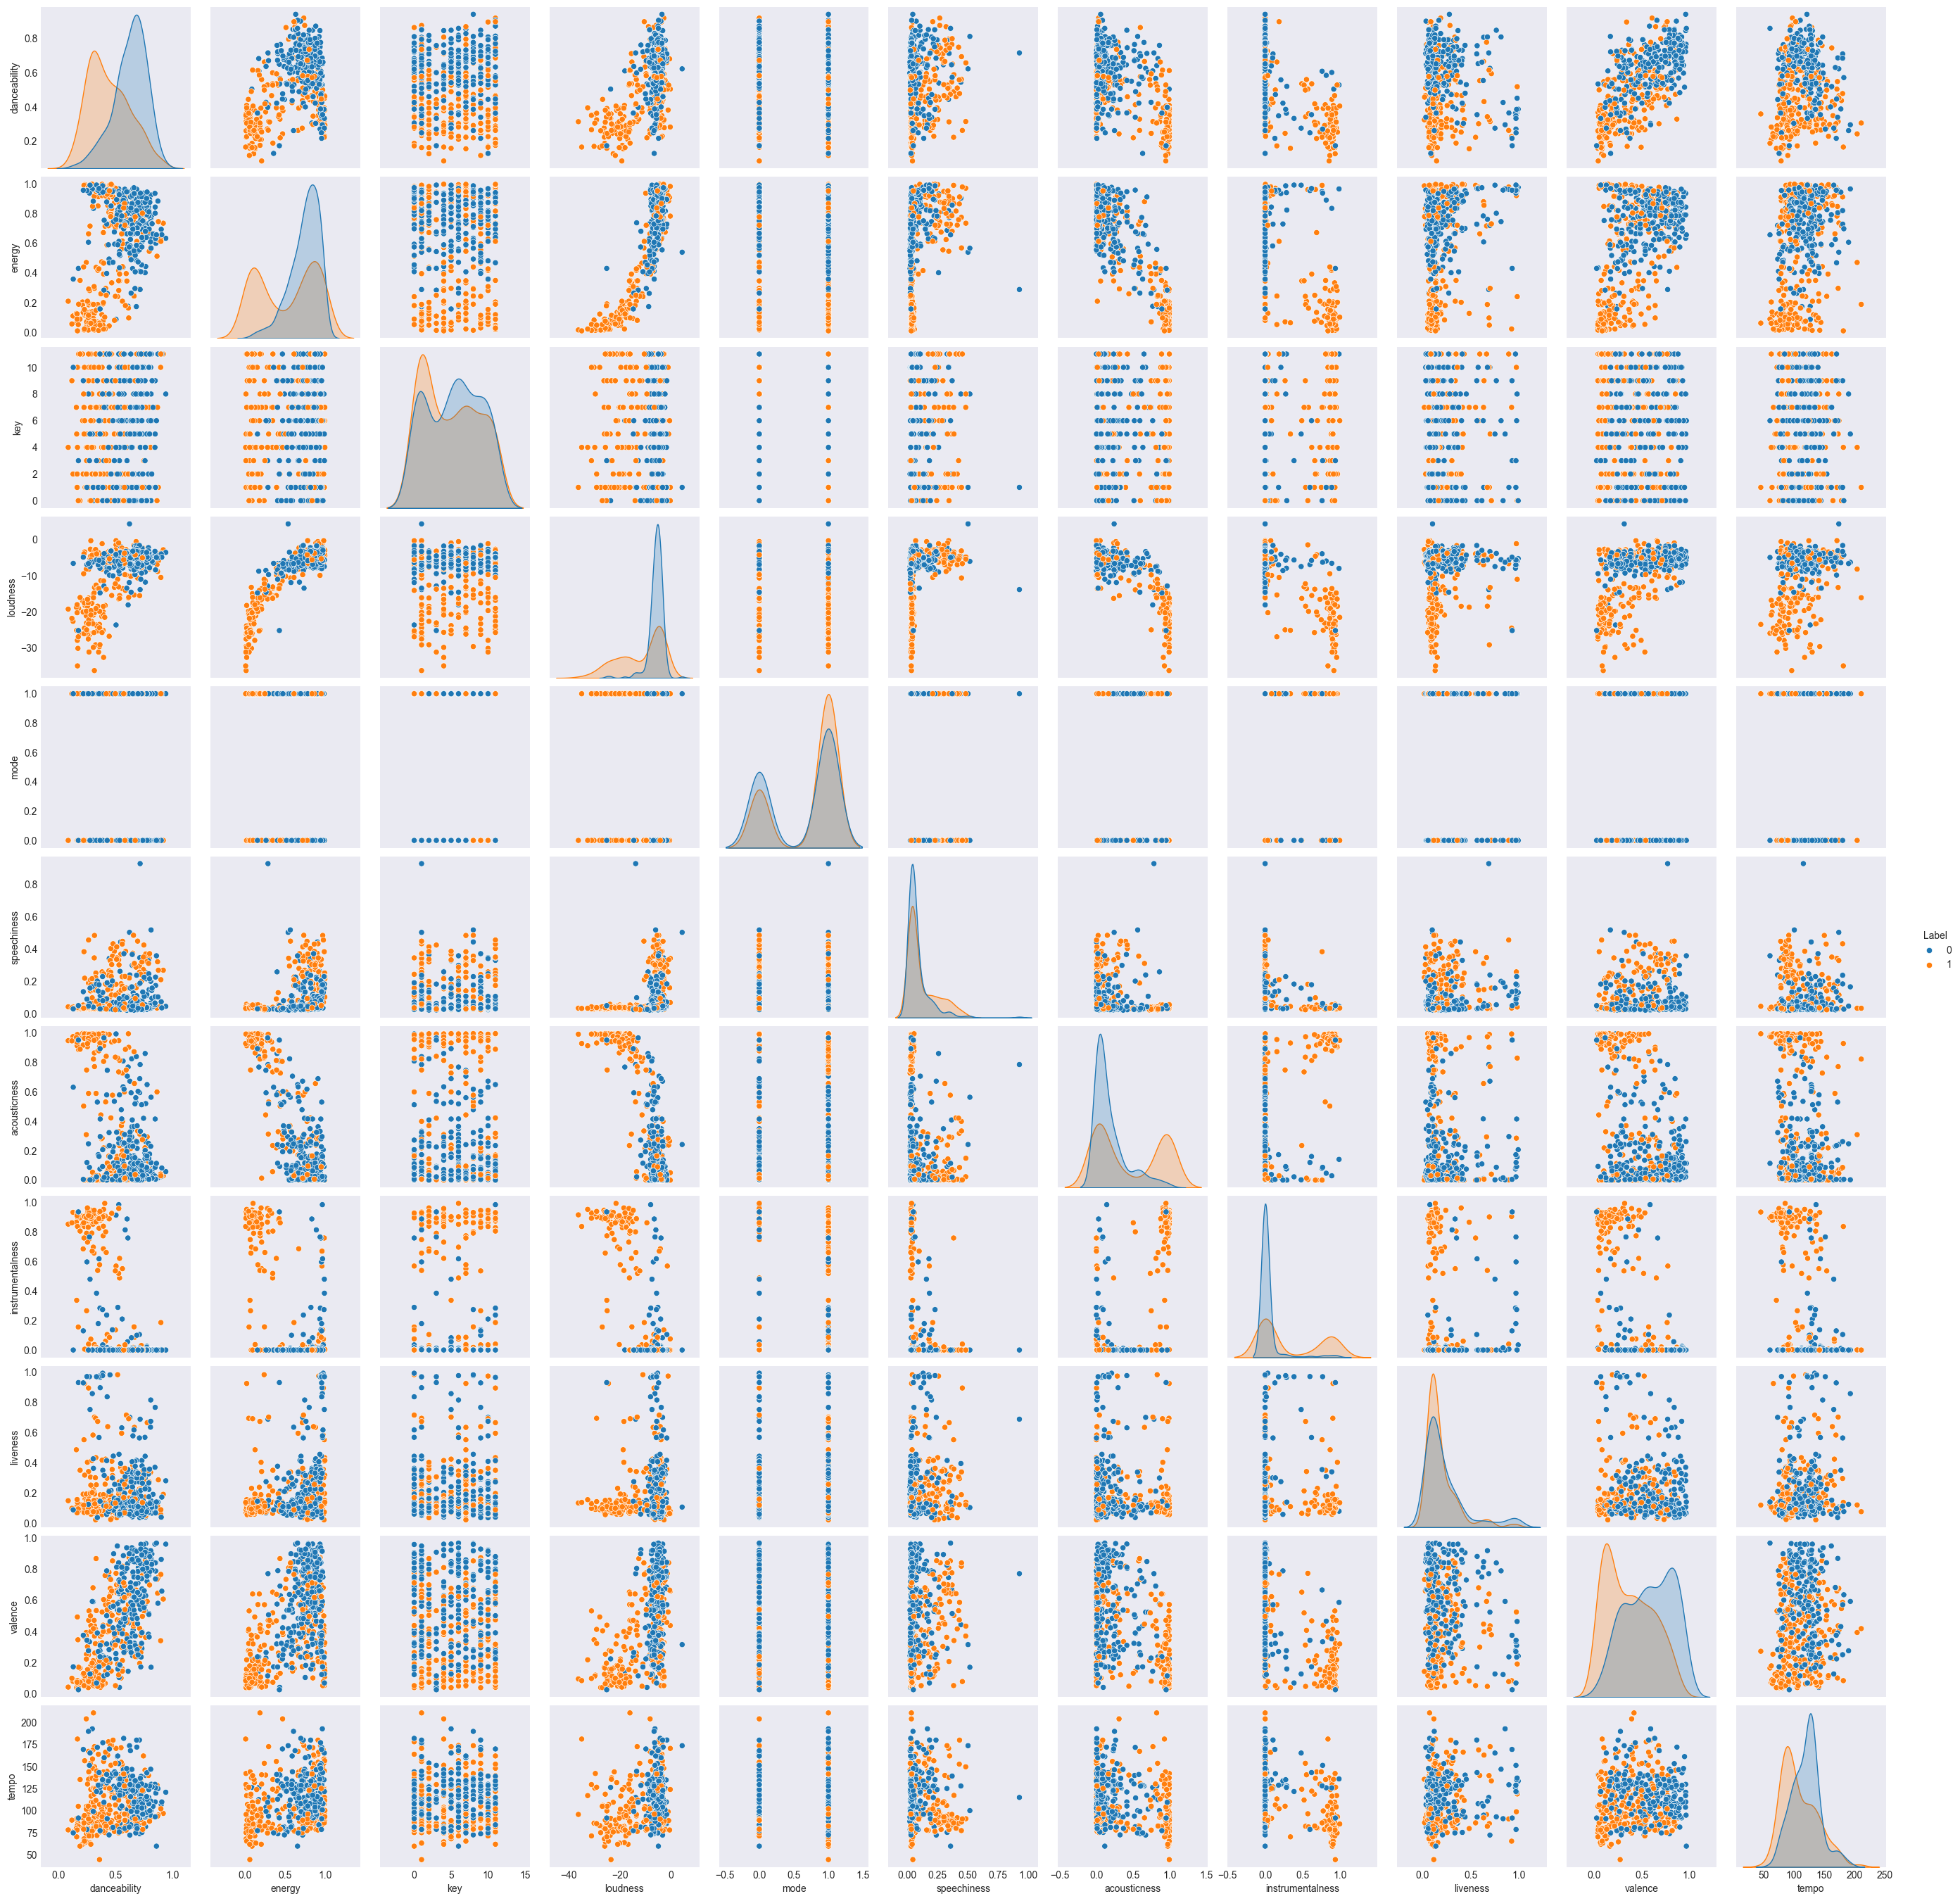

In [3]:
sns.pairplot(data, hue = "Label")

## Model With logit-Transformed Predictors

As we can see, some of the variables are constrained between 0 and 1 and some aren't. Therefore, I have decided to apply a logit-transformation to most variables constrained between 0 and 1 so that they mesh well with the other variables in an eventual model.

However, as we shall see, an additional scaling of the non-categorical variables will also be required if we desire to fit all variables in the same model.

In [4]:
vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

In [5]:

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(logit)

Below is a pair plot of the transformed variables, with hue given by the label. In my opinion the resulting distributions look nice and are even mostly centered at 0 with comparable ranges.

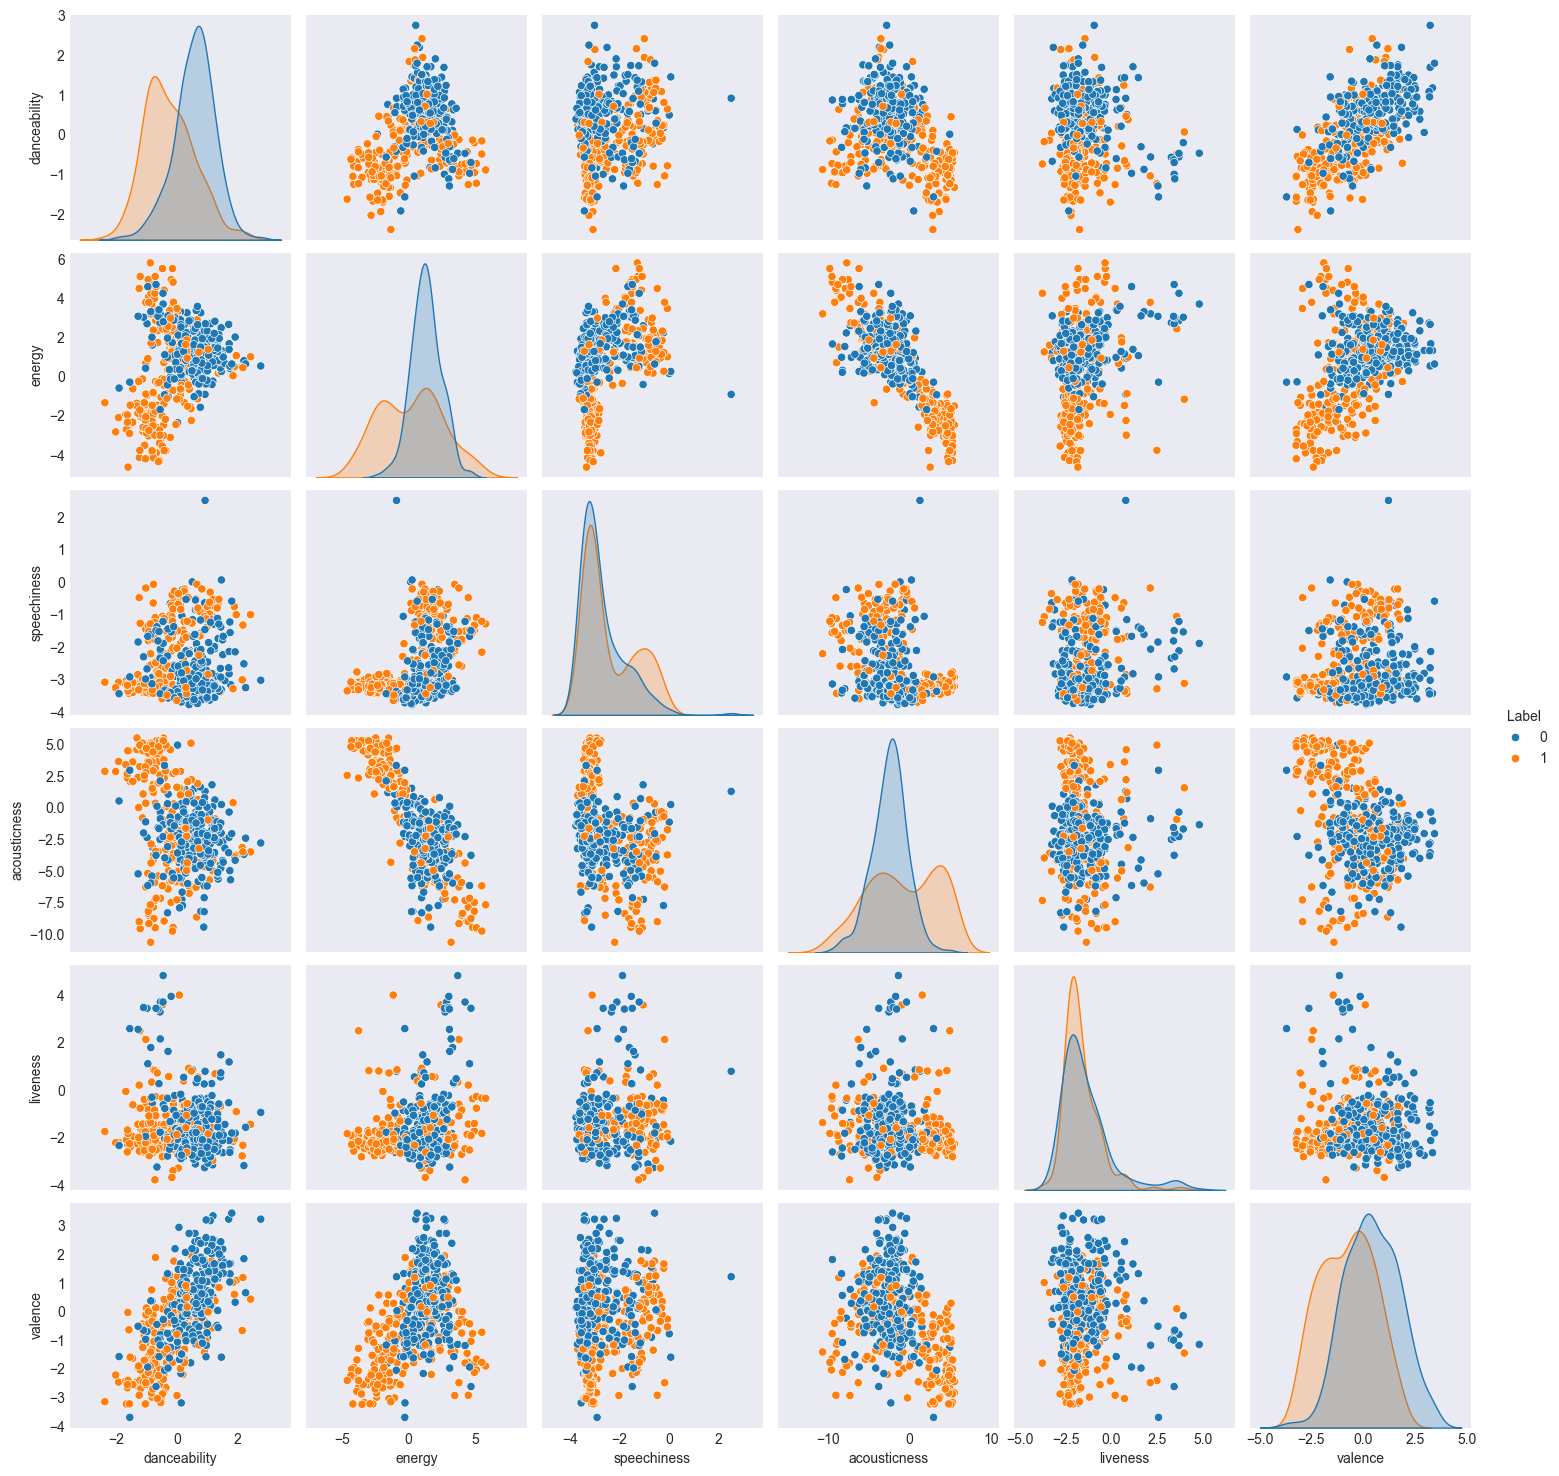

In [6]:
sns.pairplot(transformed_data[vars_to_transform + ["Label"]], hue = "Label")

### Model Using the Transformed Data

In [7]:

predictors_train, predictors_test, response_train, response_test = generate_train_test_split(transformed_data)

In [8]:
transformed_model = LogisticRegression()
transformed_model.fit(predictors_train, response_train)

c:\Users\toven\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

As can be seen above, the model converges badly in this case. Below I apply a standard scaling and translation to all continuous variables except for instrumentalness which is still constrained between 0 and 1.

However, as we see below, it still performs alright at prediction.

In [9]:
predicted = transformed_model.predict(predictors_test)
confusion_table(predicted, response_test)

Truth       0   1
Predicted        
0          41  13
1          12  35

### Scaling data

As stated above, we apply a standard scaling procedure `sklearn.preprocessing.scale()`to all continuous variables except instrumentalness.
This improves model convergence and provides a slight further improvement on prediction.

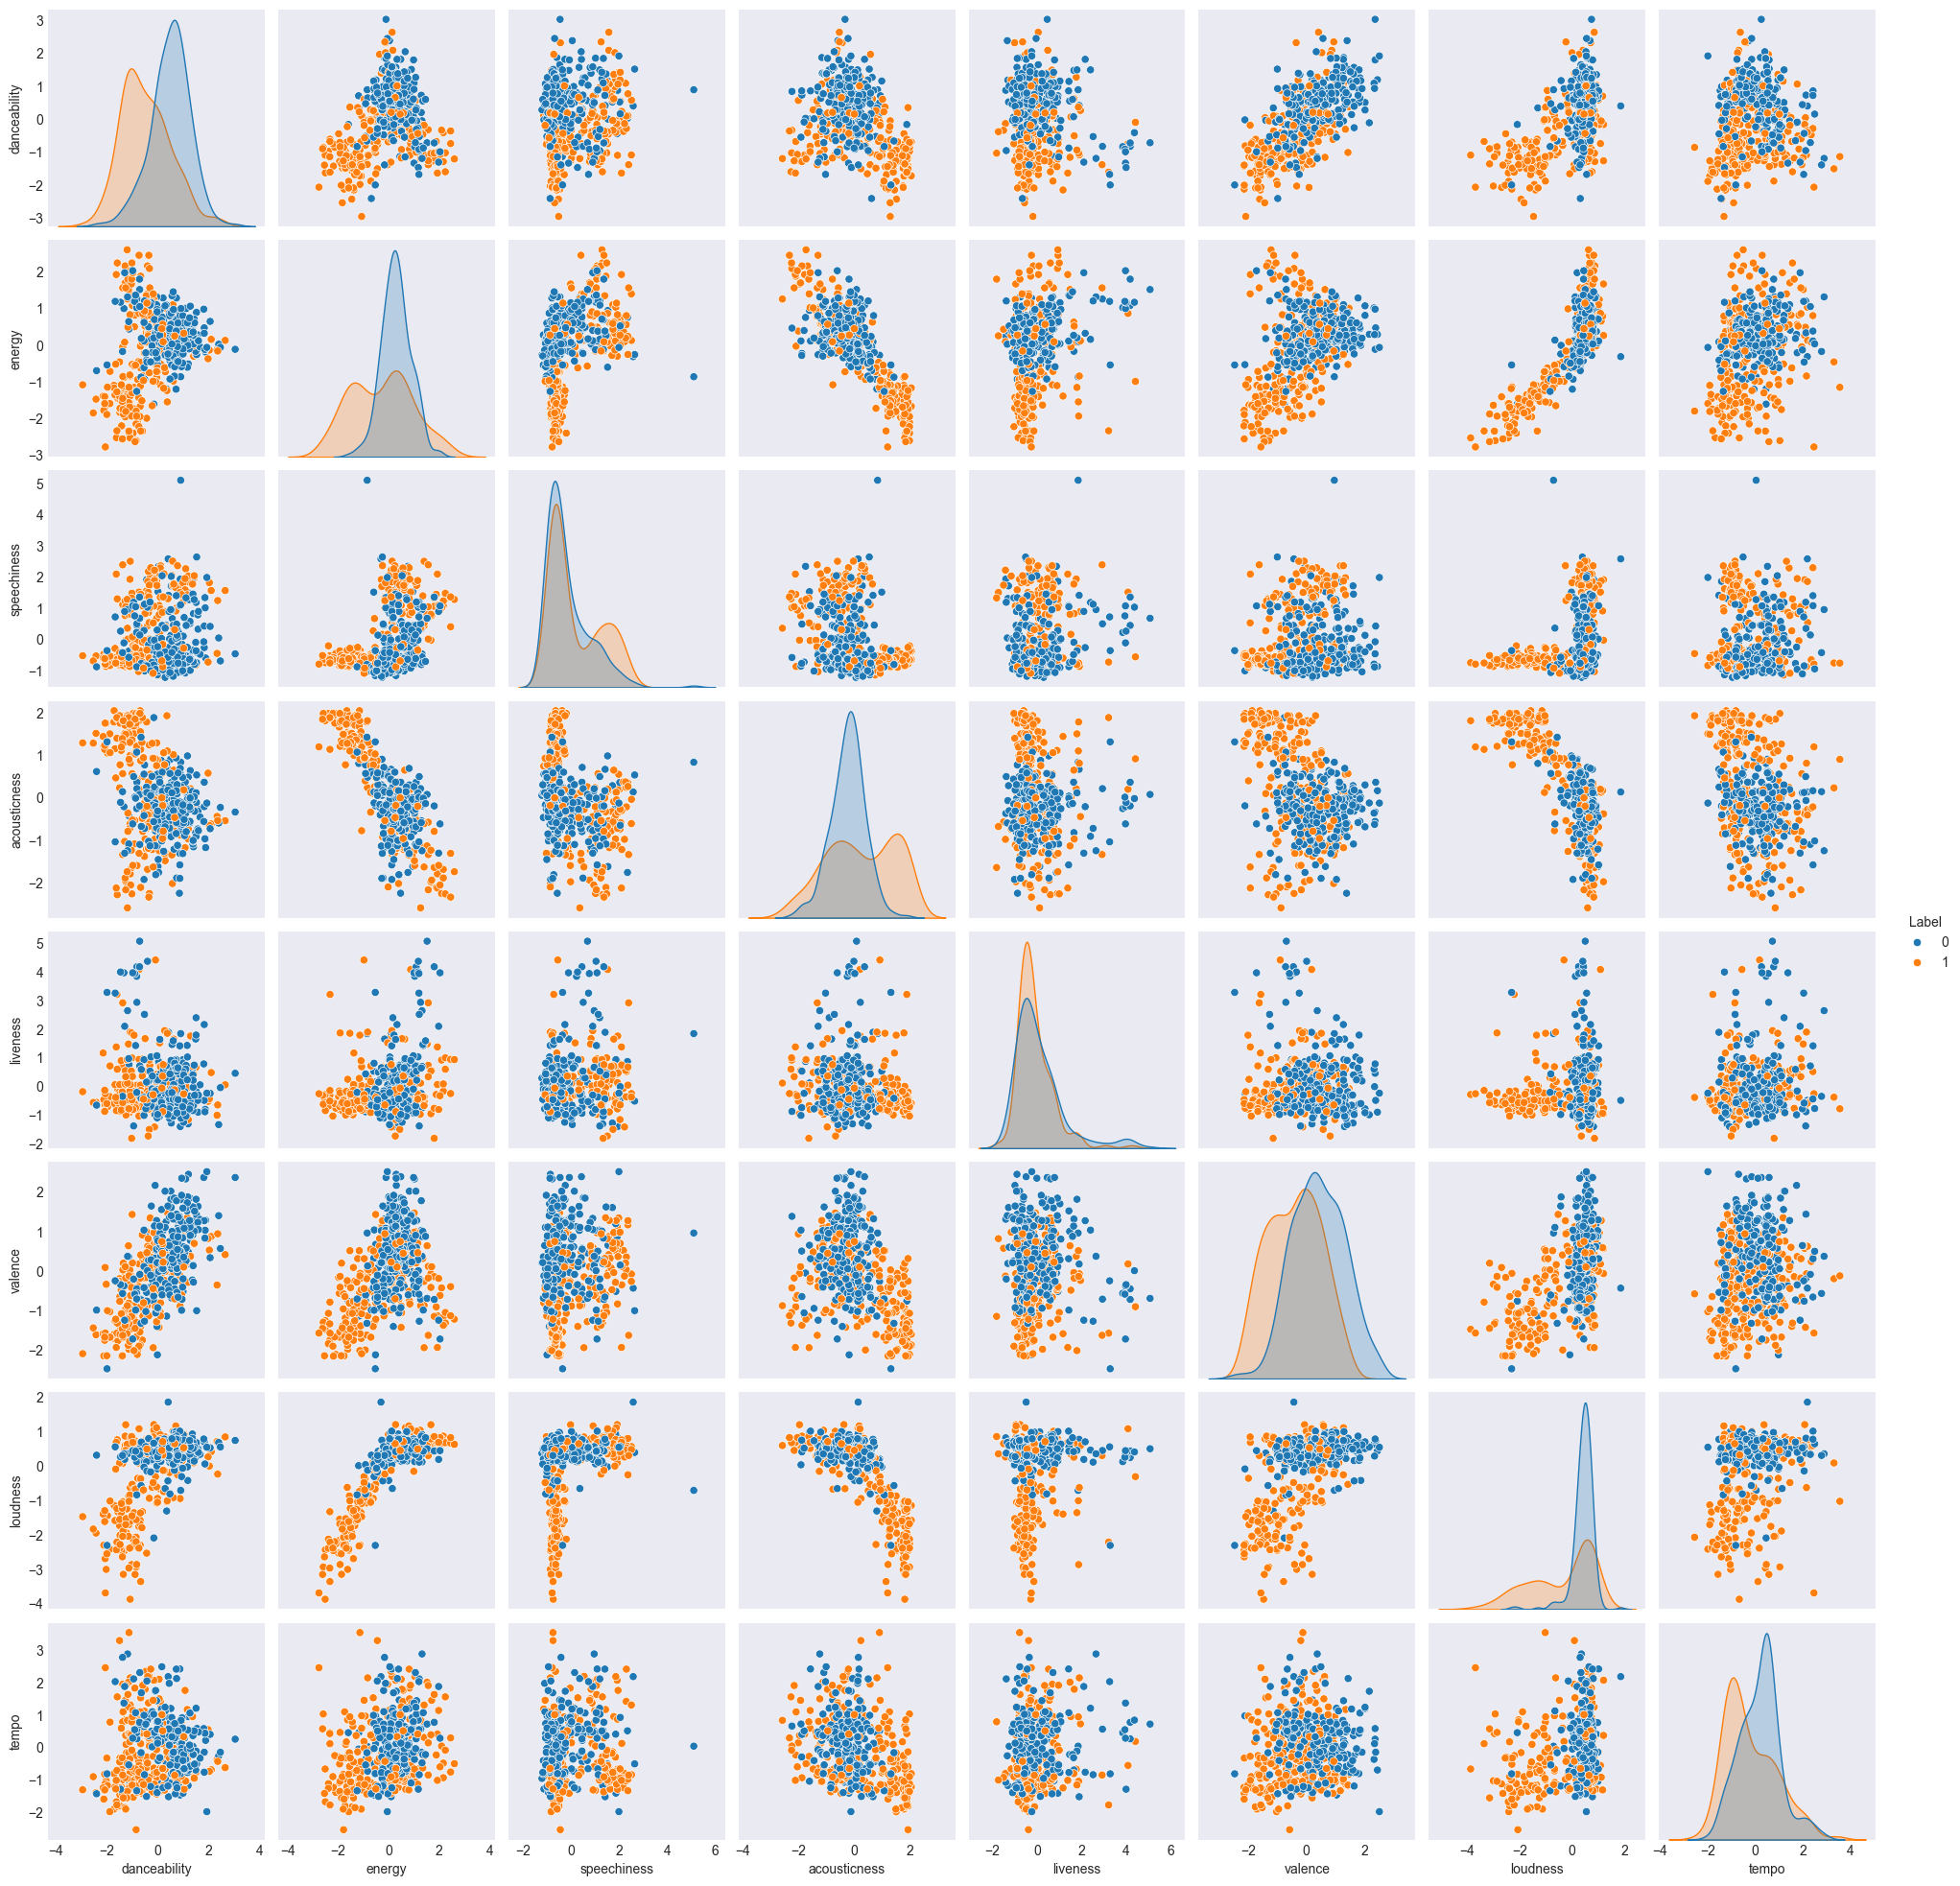

In [10]:
scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)
sns.pairplot(scaled_data[vars_to_transform + ["loudness", "tempo", "Label"]], hue = "Label")

In [11]:
predictors_train, predictors_test, response_train, response_test = (
    generate_train_test_split(scaled_data)
)

In [12]:
full_model = LogisticRegression()
full_model.fit(predictors_train, response_train)


LogisticRegression()

In [13]:
predicted = full_model.predict(predictors_test)
confusion_table(predicted, response_test)

Truth       0   1
Predicted        
0          41  13
1          12  35

## Further developing our model

The above models do not take into account interactions between terms. However, introducing interaction terms may endanger us to overfitting and other issues. On page 124 in [1] a guideline is stated, that the data set should contain at least 10 observations of each category for each variable in our model.

As can be seen by the code output below, we are thus limited to a total of 25 variables if we wish to follow the guideline. However, I am unsure how this rule relates to categorical variables.
I shall count the categorical variables not as 11 corresponding to key and 1 corresponding to mode but as 2 total variables.

For reference, the total number of "second order" interaction terms x_i*x_j between the continuous variables is C(9, 2) = 36.
If we want to follow the guideline we cannot include all of these interactions.

In [14]:
print("Number of observations with label 1: {}\nNumber of observations with label 0: {}".format((data["Label"] == 1).sum()
, (data["Label"] == 0).sum()))

Number of observations with label 1: 251
Number of observations with label 0: 252


### Second Order Interactions

We fit a model including all the variables in the previous models, all products of continuous variables (including squared variables) and an intercept. As we can see, it does perform better on the train test split, although the number of predictors (67) is worrying.

In [15]:
continuous_variables = [
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]
categorical_variables = ["key", "mode"]

In [16]:
poly = preprocessing.PolynomialFeatures(2)
continuous_interactions = pd.DataFrame(poly.fit_transform(scaled_data[continuous_variables]), columns=poly.get_feature_names_out())
interaction_data = continuous_interactions.combine_first(scaled_data)
interaction_data = interaction_data.reindex(continuous_interactions.columns.to_list() + categorical_variables + ["Label"], axis=1)

In [17]:
predictors_train, predictors_test, response_train, response_test = generate_train_test_split(
    interaction_data
)
print("Number of predictors: " + str(len(predictors_train.columns)))

Number of predictors: 67


In [18]:
interaction_model = LogisticRegression()
interaction_model.fit(predictors_train, response_train)
predicted = interaction_model.predict(predictors_test)
confusion_table(predicted, response_test)

Truth       0   1
Predicted        
0          46  12
1           7  36

In [19]:
(46 + 36)/(46 + 36 + 7 + 12)

0.8118811881188119

In [20]:
scaled_interaction_data = interaction_data.copy()
scaled_interaction_data[interaction_data.columns[:-3]] = preprocessing.scale(
    scaled_interaction_data[interaction_data.columns[:-3]]
)

In [21]:
predictors_train, predictors_test, response_train, response_test = (
    generate_train_test_split(scaled_interaction_data)
)
print("Number of predictors: " + str(len(predictors_train.columns)))

Number of predictors: 67


In [22]:
scaled_interaction_model = LogisticRegression()
scaled_interaction_model.fit(predictors_train, response_train)
predicted = scaled_interaction_model.predict(predictors_test)
confusion_table(predicted, response_test)

Truth       0   1
Predicted        
0          46  12
1           7  36

### Regularization

Since our number of predictors is very high and contains a lot of interaction terms, it may be that a large number of coefficients have little effect on prediction. In fact, since `sklearn.LogisticRegression` applies an l2 penalty term by default, this is very likely. To get an idea of if this is the case, we draw a histogram of regression coefficient values.

Text(0.5, 0, 'coefficient size')

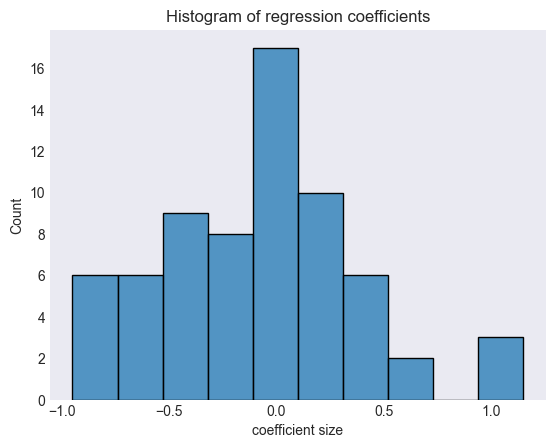

In [23]:
sns.histplot(x=scaled_interaction_model.coef_[0], bins=10)
plt.title("Histogram of regression coefficients")
plt.xlabel("coefficient size")

In the above figure it can be seen that a large portion of the coefficients have values close to 0. Thus variable selection is likely to remove a large portion of predictors without meaningfully affecting prediction performance.

It is sort of weird to apply further regularization to an l2-penalized model I think. Therefore I will instead perform a grid search w.r.t. the cost parameter.
I also apply forward selection to a non-regularized logistic regression model, using two methods, firstly minimizing the AIC and secondly using the provided `sklearn.feature_selection.SequentialFeatureSelector`

### Grid Search for the Penalized Model

Below I perform a grid search wrt the cost C in the l2-penalized logistic regression model including all second order polynomial interactions and categorical variables. The scoring is given by the accuracy as our goal is prediction.

In [24]:
predictors_train, response_train = encode_data(scaled_interaction_data)

param_grid = {"C": np.logspace(-4, 4, 100)}
model = LogisticRegression(fit_intercept=True, max_iter=1000)
cv = KFold(shuffle=True, random_state=0)
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="accuracy", cv=cv
)
grid_search.fit(predictors_train, response_train)
print("Best C:", grid_search.best_params_["C"])
print("Best cross-validation score:", grid_search.best_score_)
optimized_model = grid_search.best_estimator_

Best C: 0.03853528593710531
Best cross-validation score: 0.8171089108910892


In [ ]:
grid_search_results = pd.DataFrame(grid_search.cv_results_)[
    ["param_C"] + ["mean_test_score"]
]
grid_search_results["accuracy"] = [
    [grid_search.cv_results_["split{}_test_score".format(i)][j] for i in range(5)]
    for j in range(grid_search_results.shape[0])
]
grid_search_results["min_score"] = grid_search_results["accuracy"].apply(min)
grid_search_results["max_score"] = grid_search_results["accuracy"].apply(max)

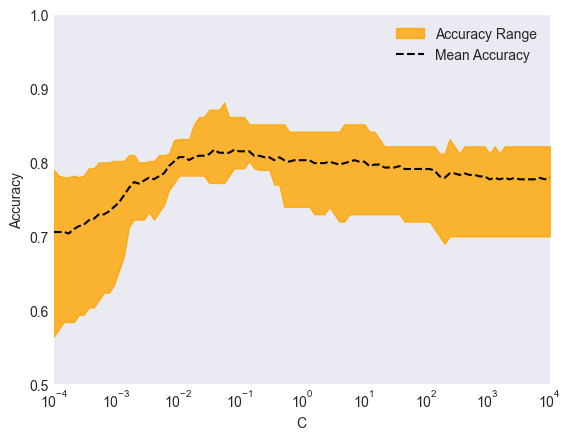

In [26]:
fig, ax = plt.subplots()
ax.fill_between(
    grid_search_results["param_C"],
    grid_search_results["min_score"],
    grid_search_results["max_score"],
    color="orange",
    alpha=0.8,
    label="Accuracy Range",
)
ax.plot(
    grid_search_results["param_C"],
    grid_search_results["mean_test_score"],
    linestyle="--",
    color="black",
    label="Mean Accuracy",
)
ax.set_xlim(
    [grid_search_results["param_C"].iloc[0], grid_search_results["param_C"].iloc[-1]]
)
ax.set_ylim([0.5, 1.0])
ax.set_xscale("log")
ax.set_xlabel("C")
ax.legend()
ax.set_ylabel("Accuracy")
fig.tight_layout
plt.savefig("grid-search-results.pdf", dpi=1000)

As we can see, the optimal cost according to GridSearchCV is very low (`C = 0.03`), and the resulting prediction on the train-test-split is worse than when the default `C = 1.0` is used.

## Various Ideas for Variable Selection

### Method Based on Minimizing AIC

In [27]:
""" predictors_train, predictors_test, response_train, response_test = (
    generate_train_test_split(scaled_interaction_data)
) """

predictors_train, response_train = encode_data(scaled_interaction_data)

metrics_minimize_AIC_method = forward_selection_minimize_AIC(
    predictors_train, response_train
)

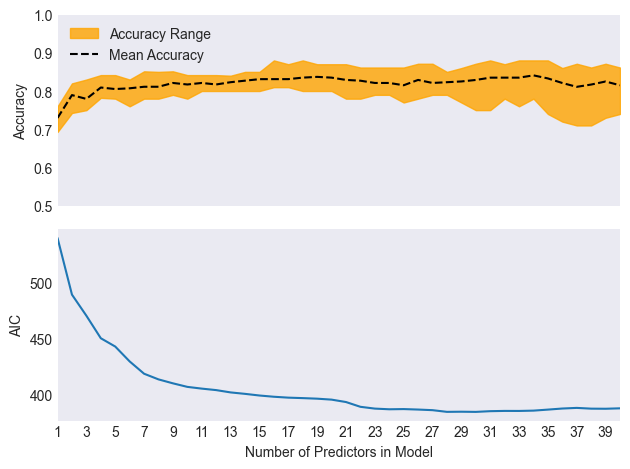

In [28]:
plot_metrics(metrics_minimize_AIC_method)

In [29]:
best_row = metrics_minimize_AIC_method.sort_values("AIC", ascending=True).iloc[0]
best_row

AIC                                                               384.052549
Cross Validation Scores    [0.8514851485148515, 0.8712871287128713, 0.821...
Selected Variables         [energy acousticness, loudness speechiness, en...
Name: 30, dtype: object

In [30]:
predictors_train, response_train = encode_data(scaled_interaction_data)
predictors_train = predictors_train[best_row["Selected Variables"]]
param_grid = {"C": np.logspace(-4, 4, 100)}
model = LogisticRegression(fit_intercept=True, max_iter=1000)
cv = KFold(shuffle=True, random_state=0)
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, scoring="accuracy", cv=cv
)
grid_search.fit(predictors_train, response_train)
print("Best C:", grid_search.best_params_["C"])
print("Best cross-validation score:", grid_search.best_score_)
optimized_model = grid_search.best_estimator_

Best C: 45.34878508128591
Best cross-validation score: 0.8309306930693069


In [31]:
grid_search_results = pd.DataFrame(grid_search.cv_results_)[
    ["param_C"] + ["mean_test_score"]
]
grid_search_results["accuracy"] = [
    [grid_search.cv_results_["split{}_test_score".format(i)][j] for i in range(5)]
    for j in range(grid_search_results.shape[0])
]
grid_search_results["min_score"] = grid_search_results["accuracy"].apply(min)
grid_search_results["max_score"] = grid_search_results["accuracy"].apply(max)

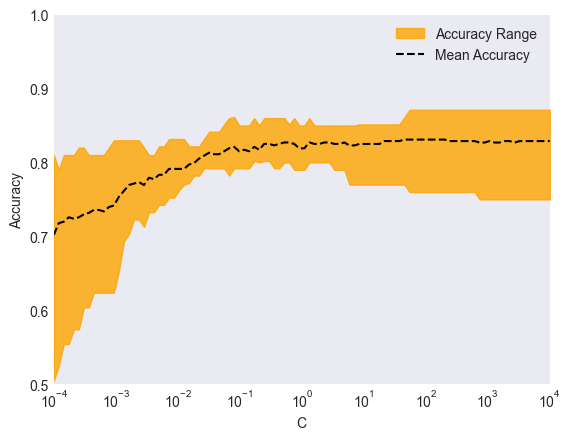

In [32]:
fig, ax = plt.subplots()
ax.fill_between(
    grid_search_results["param_C"],
    grid_search_results["min_score"],
    grid_search_results["max_score"],
    color="orange",
    alpha=0.8,
    label="Accuracy Range",
)
ax.plot(
    grid_search_results["param_C"],
    grid_search_results["mean_test_score"],
    linestyle="--",
    color="black",
    label="Mean Accuracy",
)
ax.set_xlim(
    [grid_search_results["param_C"].iloc[0], grid_search_results["param_C"].iloc[-1]]
)
ax.set_ylim([0.5, 1.0])
ax.set_xscale("log")
ax.set_xlabel("C")
ax.legend()
ax.set_ylabel("Accuracy")
fig.tight_layout
plt.savefig("grid-search-results.pdf", dpi=1000)

### Combo method, variables chosen by sequential feature selector and number chosen by AIC

## TL;DR

Based on the above results it seems that the best number of variables is around 22 and they should be picked by minimizing the AIC

Sources

[1] An Introduction to Categorical Data Analysis (Third Edition), Alan Agresti, 2019 Wiley